## Ensemble variation in cloud cover
### GEFS TCC
The NOAA GEFS numerical weather prediction (NWP) model is a 30-member ensemble version of the GFS model. NOAA has this description:
> The GEFS attempts to quantify the amount of uncertainty in a forecast by generating an ensemble of multiple forecasts, each minutely different, or perturbed, from the original observations. With global coverage, GEFS is produced four times a day with weather forecasts going out to 16 days.

We will look at the fleet-wide weighted average standard deviation of the Total Cloud Cover (TCC) percentage across all 30 members, weighted by the solar plant capacities. For example, if all 30 members forecast that a given location and time will have no clouds (TCC = 0%), then the standard deviation will be *low*, so we assume that our power forecast has *low uncertainty*. If there is significant disagreement between the 30 members (some members forecast no or low cloud cover, while others forecast high cloud cover), then the standard deviation will be *high*, and we assume that any forecast will have *high uncertainty*. 

We use TCC instead of irradiance for two reasons: 
 1) GEFS may have issues with modeling irradiance*, and, more importantly
 2) We are looking at *relative* uncertainty, and using TCC means we don't have to normalize irradiance to clear sky irradiance. 

_Note: Total CLoud Cover does not differentiate between low, mid, and high clouds, which can have different impacts on irradiance [1]. However, the regression models used later to estimate uncertainty were retrained with seperate cloud cover variables (and combinations of two of the three), and results did not appear to improve. This is an area for potential exporation/improvement. Similarly, irradiance (DSWRF) from GEFS was not tested in this work, but may ebe useful after normalizing the clear sky irradiance._

*See https://www.energy.gov/sites/default/files/2019/10/f67/7%20Solar-Forecasting-2-Annual-Review_University-of-Arizona.pdf and https://pvlib-python.readthedocs.io/en/v0.4.0/forecasts.html. 

[1] https://pdfs.semanticscholar.org/ab2c/0cf0f80d6775ab49ea86fa34dbdccf7dbae8.pdf

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

from herbie import Herbie
from paint.standard2 import cm_tmp, cm_wind, cm_wave_height, cm_pcp
from toolbox import EasyMap, pc
import xarray as xr
import pandas as pd
import datetime
from datetime import timedelta
import time
import pickle

## Plant data

Let's load plant data again:

In [2]:
plants_df = pd.read_csv('pv_fleet_metadata_rev3.csv') # read in as a Pandas DataFrame
plants_df = plants_df[plants_df['ac_capacity']>=10].copy().reset_index()
num_plants = len(plants_df.index) # number of plants

To keep it simple at the beginning, let's just work with the first 2 plants:

In [3]:
plants_df_partial = plants_df.head(2).copy()

### GEFS Total Cloud Cover
Now, let's use `Herbie` to get Total Cloud Cover from GEFS. Total Cloud Cover is `TCDC` in the GEFS inventory, even though we refer to it as TCC elsewhere. We will also pick a single member of the GEFS ensemble - let's use "p01" to start. See [1] for more details.

[1] https://herbie.readthedocs.io/en/stable/user_guide/_model_notebooks/gefs.html

In [4]:
date = '2021-01-02 06:00'
member='p01'
ds = Herbie(
    date=date,
    model='gefs',
    product="atmos.5",
    member=member,
    fxx=36).xarray('TCDC',remove_grib=True)

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Jan-02 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [C:\Users\whobbs\data\gefs\20210102]


And preview the dataset. Note that "tcc" is the variable name for Total Cloud Cover within the xarray dataset.

In [5]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:              (latitude: 361, longitude: 720)
Coordinates:
    number               int32 4B 1
    time                 datetime64[ns] 8B 2021-01-02T06:00:00
    step                 timedelta64[ns] 8B 1 days 12:00:00
    atmosphere           float64 8B 0.0
  * latitude             (latitude) float64 3kB 90.0 89.5 89.0 ... -89.5 -90.0
  * longitude            (longitude) float64 6kB 0.0 0.5 1.0 ... 359.0 359.5
    valid_time           datetime64[ns] 8B 2021-01-03T18:00:00
Data variables:
    tcc                  (latitude, longitude) float32 1MB 4.0 4.0 ... 20.0 20.0
    gribfile_projection  object 8B None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   gefs
    product:                 atmos.5
    description:             Global Ensemble Forecast System (GEFS)
    remote_grib:             https://noaa-gefs-pds.s3.amazonaws.com/gefs.2021...
    local_grib:              C:\Users\whobbs\data\gefs\20210102\subset_c60efd...
    searchString:            TCDC

Similar to what we did with the HRRR forecast, we will slice the dataset to reduce file size and make it easier to plot. Note that GEFS is mush lower resolution than HRRR, so file size is not a big issue. 

In [6]:
# Define extent (left lon, right lon, lower lat, upper lat)
# longitude has to be between 0 and 360
region_extent = [-92, -80, 29, 36]

min_lon = (region_extent[0]+360) % 360
max_lon = (region_extent[1]+360) % 360
min_lat = region_extent[2]
max_lat = region_extent[3]

# slice to region extent
# note that lat is sliced max to min because of order that latitude is stored in with GEFS
# (I think...)
ds = ds.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon,max_lon))

### Pull TCC for each plant
Now, let's pull out the data from the dataset for each plant and put it in a dataframe:

In [7]:
# GEFS uses longitudes in [0,360), so use modulo to convert lon to be 0 <= lon < 360
lon_gefs = [(x + 360) % 360 for x in plants_df_partial.longitude]

# select the whole list of sites at once
lats = xr.DataArray(plants_df_partial.latitude.values, dims='plant_number') 
lons = xr.DataArray(lon_gefs, dims='plant_number')
df1 = ds.sel(latitude = lats, longitude = lons, method = 'nearest').to_dataframe()

# assign ac capacity based on plant_number and index in plants_df_partial
df1 = df1.merge(plants_df_partial[['ac_capacity']], left_on='plant_number', right_index=True)

# preview the dataframe
df1.head()

,number,time,step,atmosphere,latitude,longitude,valid_time,tcc,gribfile_projection,ac_capacity
plant_number,,,,,,,,,,
0,1,2021-01-02 06:00:00,1 days 12:00:00,0.0,30.5,275.5,2021-01-03 18:00:00,55.0,None,213.0
1,1,2021-01-02 06:00:00,1 days 12:00:00,0.0,32.5,276.5,2021-01-03 18:00:00,88.0,None,204.0


And let's make a map. 

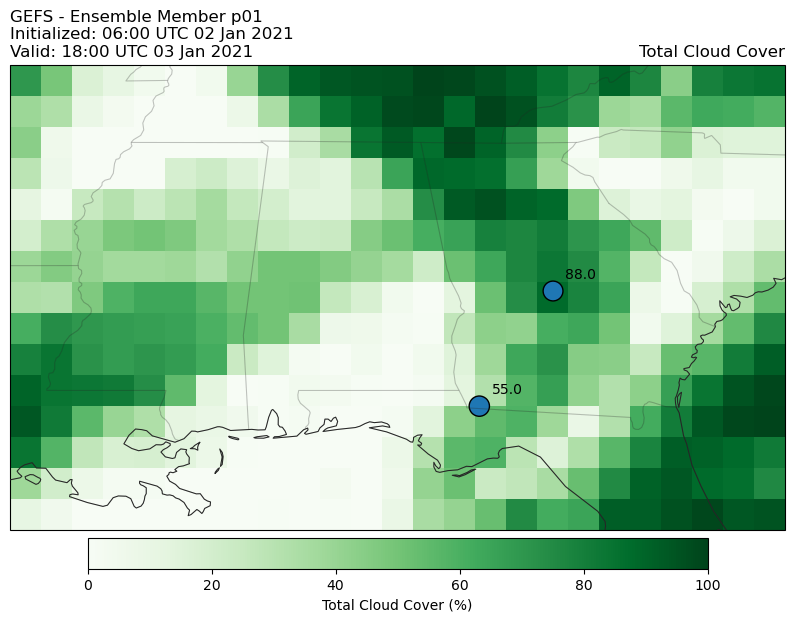

In [8]:
ax = EasyMap("50m", crs=ds.herbie.crs, figsize=[10, 10]).STATES().BORDERS().ax
p = ax.pcolormesh(
    ds.longitude, ds.latitude, ds['tcc'], transform=pc, cmap="Greens", vmin=0
)

# add a colorbar
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.01,
    shrink=0.8,
    label=f"{ds['tcc'].GRIB_name} ({ds['tcc'].GRIB_units})",
)

# add plant markers with size corresponding to ac capacity
plt.scatter(plants_df_partial.longitude, plants_df_partial.latitude, s=plants_df_partial.ac_capacity,
            edgecolors='black', transform=pc)

# add data labels
for i, txt in enumerate(df1['tcc']):
    plt.annotate(txt, (plants_df_partial.longitude[i]+.2, plants_df_partial.latitude[i]+.2))

ax.set_title(
    f"{ds.model.upper()} - Ensemble Member {member} \
    \nInitialized: {ds.time.dt.strftime('%H:%M UTC %d %b %Y').item()} \
    \nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
    loc="left",
)
ax.set_title(ds['tcc'].GRIB_name, loc="right")
plt.show()

### Weighted average TCC
We can calculate the weighted average total cloud cover, weighted by plant AC capacity, like this:

In [9]:
weighted_avg_tcc1 = df1.filter(regex='tcc').multiply(df1['ac_capacity'].values,axis='index').sum()/df1['ac_capacity'].sum()
weighted_avg_tcc1 = weighted_avg_tcc1.values[0]
print('Weighted Average TCC: ' + str(weighted_avg_tcc1))

Weighted Average TCC: 71.14388489208633


### Repeating for more ensemble members
Now, let's make a helper function to repeat that for different forecasts/members:

In [10]:
def sample_tcc_function(member, date, plants_df, plot=True):
    ds = Herbie(
        date=date,
        model='gefs',
        product="atmos.5",
        member=member,
        fxx=36).xarray('TCDC',remove_grib=True)

    # slice to region extent
    ds = ds.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon,max_lon))

    # select values for each plant, assign ac capacity
    # GEFS uses longitudes in [0,360), so use modulo to convert lon to be 0 <= lon < 360
    lon_gefs = [(x + 360) % 360 for x in plants_df.longitude]
    lats = xr.DataArray(plants_df.latitude.values, dims='plant_number') 
    lons = xr.DataArray(lon_gefs, dims='plant_number')
    df = ds.sel(latitude = lats, longitude = lons, method = 'nearest').to_dataframe()
    df = df.merge(plants_df[['ac_capacity']], left_on='plant_number', right_index=True)

    if plot==True:
        # plot
        ax = EasyMap("50m", crs=ds.herbie.crs, figsize=[10, 10]).STATES().BORDERS().ax
        p = ax.pcolormesh(
            ds.longitude, ds.latitude, ds['tcc'], transform=pc, cmap="Greens", vmin=0
        )

        # add a colorbar
        plt.colorbar(
            p,
            ax=ax,
            orientation="horizontal",
            pad=0.01,
            shrink=0.8,
            label=f"{ds['tcc'].GRIB_name} ({ds['tcc'].GRIB_units})",
        )

        # add plant markers with size corresponding to ac capacity
        plt.scatter(plants_df.longitude, plants_df.latitude, s=plants_df.ac_capacity,
                    edgecolors='black', transform=pc)

        # add data labels
        for i, txt in enumerate(df['tcc']):
            plt.annotate(txt, (plants_df.longitude[i]+.2, plants_df.latitude[i]+.2))

        ax.set_title(
            f"{ds.model.upper()} - Ensemble Member {member} \
            \nInitialized: {ds.time.dt.strftime('%H:%M UTC %d %b %Y').item()} \
            \nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
            loc="left",
        )
        ax.set_title(ds['tcc'].GRIB_name, loc="right")
        plt.show()

    # weighted average tcc
    weighted_avg_tcc = df.filter(regex='tcc').multiply(df['ac_capacity'].values,axis='index').sum()/df['ac_capacity'].sum()
    weighted_avg_tcc = weighted_avg_tcc.values[0]
    return df, weighted_avg_tcc

Let's try it again for another one of the GEFS members, `p02`. We will write the TCC values for each plant to a new DataFrame, `df2`, and the weighted average TCC to `weighted_avg_tcc2`.

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Jan-02 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


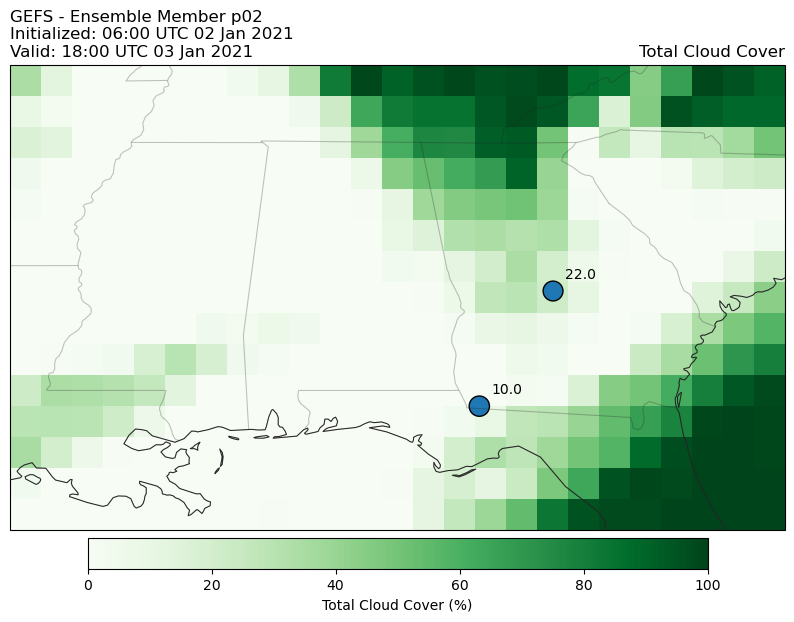

Weighted Average TCC: 15.870503597122303


In [11]:
member = 'p02'
df2, weighted_avg_tcc2 = sample_tcc_function(member=member, date=date, plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc2))

And again for `p03`:

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Jan-02 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


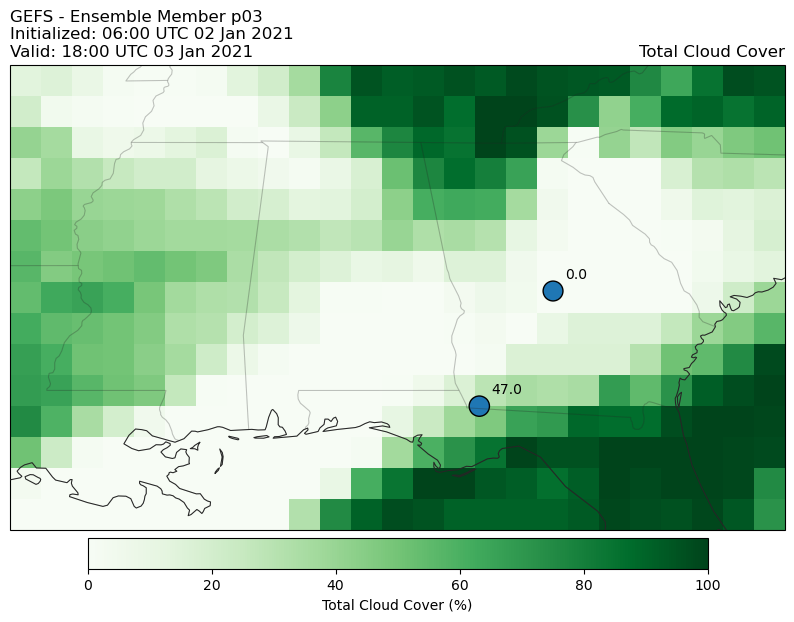

Weighted Average TCC: 24.007194244604317


In [12]:
member = 'p03'
df3, weighted_avg_tcc3 = sample_tcc_function(member=member, date=date, plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc3))

If there were only 3 members, we could stop there and calculate the standard deviation of weighted average TCCs from each member:

In [13]:
print(np.std([weighted_avg_tcc1, weighted_avg_tcc2, weighted_avg_tcc3]))

24.365777502399002


This is a relatively large standard deviation, indicating high uncertainty.

### Again for another day
Let's do the same thing, but for the next day:

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Jan-03 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [C:\Users\whobbs\data\gefs\20210103]


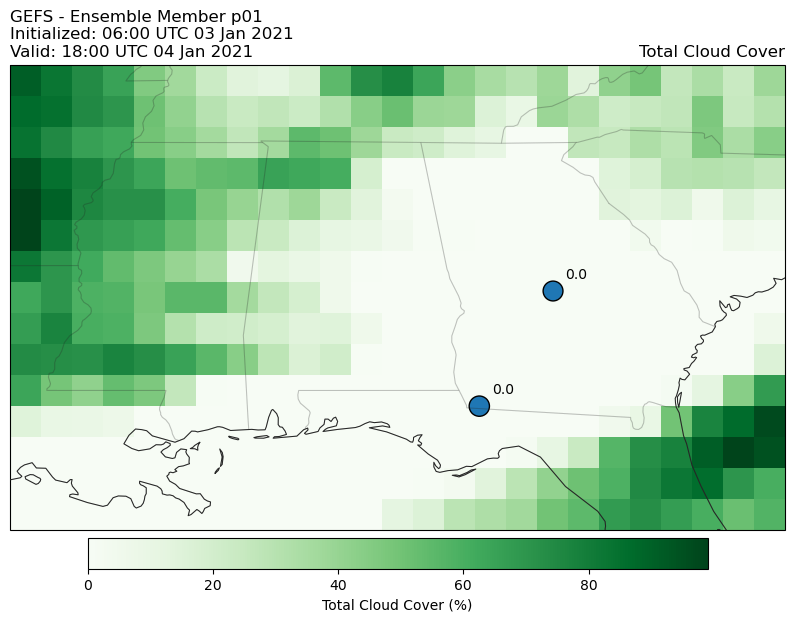

Weighted Average TCC: 0.0
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Jan-03 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


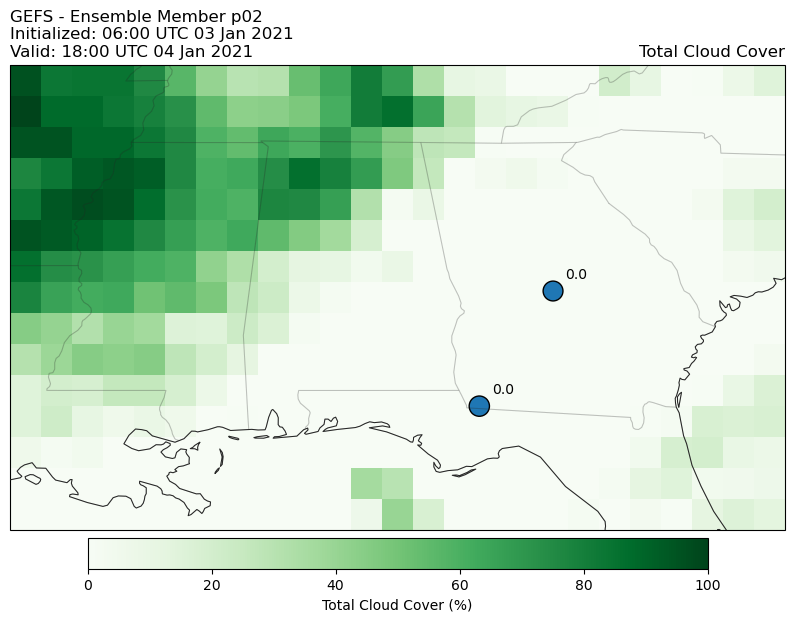

Weighted Average TCC: 0.0
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Jan-03 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


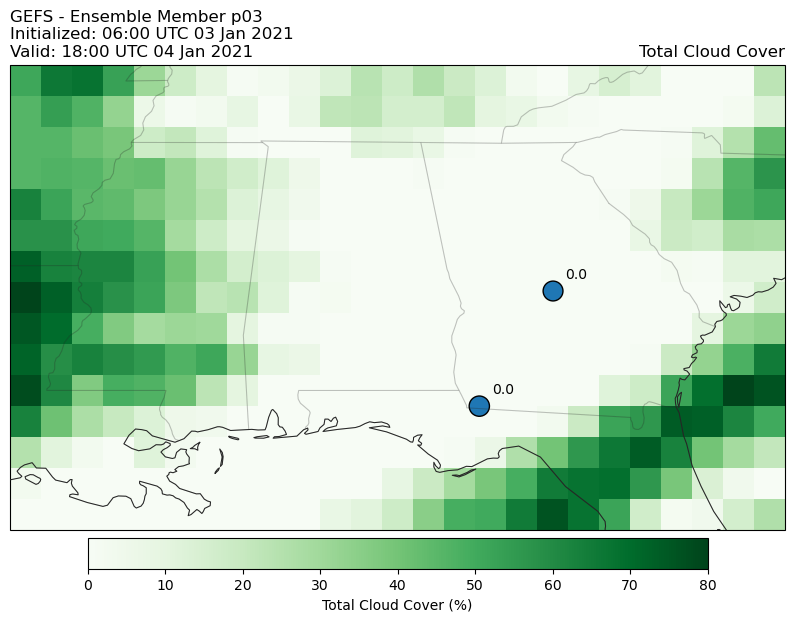

Weighted Average TCC: 0.0
StDev of Weighted Avg TCC: 0.0


In [14]:
date = '2021-01-03 06:00'

member = 'p01'
df1, weighted_avg_tcc1 = sample_tcc_function(member=member, date=date, plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc1))

member = 'p02'
df2, weighted_avg_tcc2 = sample_tcc_function(member=member, date=date, plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc2))

member = 'p03'
df3, weighted_avg_tcc3 = sample_tcc_function(member=member, date=date, plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc3))

print('StDev of Weighted Avg TCC: ' + str(np.std([weighted_avg_tcc1, weighted_avg_tcc2, weighted_avg_tcc3])))

The weighted average TCC is zero in all three members, resulting in zero standard deviation, indicating low uncertainty. 

### And for a third day
One more time:

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Jan-04 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [C:\Users\whobbs\data\gefs\20210104]


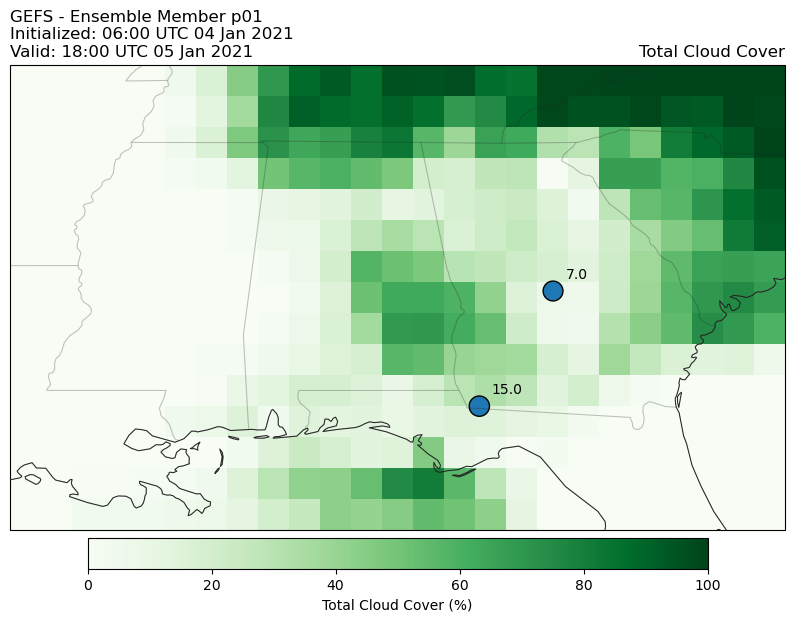

Weighted Average TCC: 11.086330935251798
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Jan-04 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


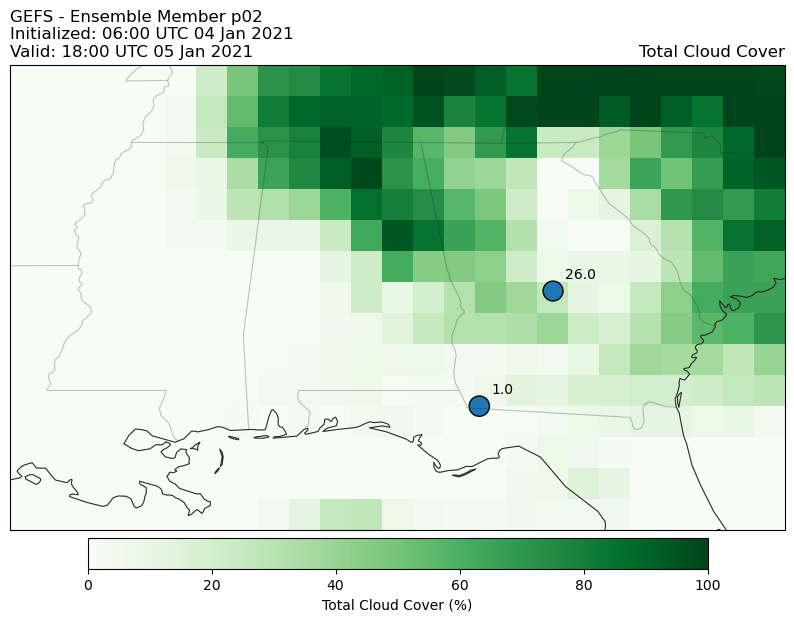

Weighted Average TCC: 13.23021582733813
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Jan-04 06:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws


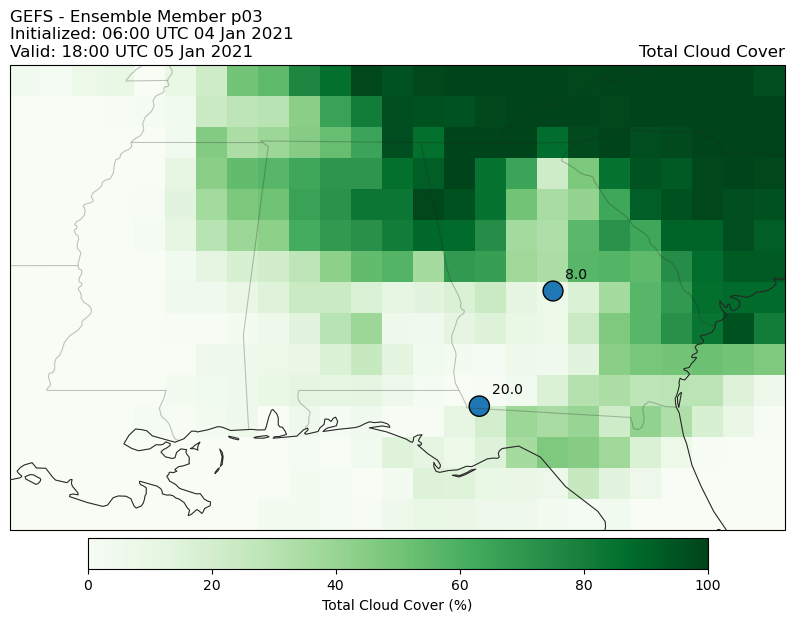

Weighted Average TCC: 14.129496402877697
StDev of Weighted Avg TCC: 1.2765319357718812


In [15]:
date = '2021-01-04 06:00'

member = 'p01'
df1, weighted_avg_tcc1 = sample_tcc_function(member=member, date=date, plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc1))

member = 'p02'
df2, weighted_avg_tcc2 = sample_tcc_function(member=member, date=date, plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc2))

member = 'p03'
df3, weighted_avg_tcc3 = sample_tcc_function(member=member, date=date, plants_df=plants_df_partial)
print('Weighted Average TCC: ' + str(weighted_avg_tcc3))

print('StDev of Weighted Avg TCC: ' + str(np.std([weighted_avg_tcc1, weighted_avg_tcc2, weighted_avg_tcc3])))

This indicates medium uncertainty, at least compared to the first two days. 

## TODO:
1. adjust 3hr avg to 1hr interval
2. run for all plants
3. run for multiple horizons? (fastherbie)
4. find better sample date range? 
    - 2021-04-02 is clear
    -  2021-01-03 has high error (underforecast), 4th is very clear, 5th is clear with higher error

For item 1:

Because GEFS has 3 hour intervals, and total cloud cover represents the 0-3 hour average [1], but we want 1 hour interval data, we make two additional copies of the data with the timestamps shifted -1 and -2 hours, concatenate, and then sort.

[1] See "TCDC", total cloud cover, here https://www.nco.ncep.noaa.gov/pmb/products/gens/gep01.t00z.pgrb2a.0p50.f003.shtml.

_Note: We could have resampled to hourly and backfilled, but if there are gaps in our forecast timeseries (e.g., we left out nighttime from our FastHerbie pull), we wouldn't know which hours were "real" forecasts and which were filled in._

Sample code from https://github.com/williamhobbs/renewable-forecasting-examples/blob/main/herbie_pvlib_proof_of_concept.ipynb, https://github.com/williamhobbs/renewable-forecasting-tools/blob/main/herbie_gefs_tools.py:

```python
# calculate stdev of weighted avg tcc for each valid_time_utc
weighted_avg_tcc.insert(0,'tcc_std',weighted_avg_tcc.filter(regex='tcc').std(axis=1))

weighted_avg_tcc = weighted_avg_tcc.reset_index().set_index('valid_time_utc_end_of_interval')
temp1 = weighted_avg_tcc.copy()
temp2 = weighted_avg_tcc.copy()
temp1.index = weighted_avg_tcc.index.shift(-1, freq='h')
temp2.index = weighted_avg_tcc.index.shift(-2, freq='h')
weighted_avg_tcc = pd.concat([weighted_avg_tcc, temp1, temp2])
```

### Expanding to all 30 ensemble members and all plants
Now that we've done a few limited illustrations, lets try looping through all 30 ensemble members, and calculating weighted average TCC for all of the plants in our list. _Note that this could take a few minutes to run._

In [ ]:
date = '2023-02-11 06:00'

num_members = 30

# list of GEFS ensemble members, e.g., 'p01', 'p02', etc.
member_list = [f"p{x:02d}" for x in range(1, num_members+1)]

df_dict = {}
weighted_avg_tcc_dict = {}
for x in range(0, num_members):
    df_dict[x], weighted_avg_tcc_dict[x] = sample_tcc_function(member=member_list[x], date=date, plants_df=plants_df, plot=False)

std_wavg_tcc = np.std(list(weighted_avg_tcc_dict.values()))
print(print('StDev of Weighted Avg TCC: ' + str(std_wavg_tcc)))